In [1]:
import pandas as pd 
from tableone import TableOne
import numpy as np 
import pandas as pd 
import sys 
from sklearn.metrics import roc_auc_score,recall_score,precision_score
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.preprocessing import preprocess_input_df 
from aequitas.bias import Bias 
from aequitas.fairness import Fairness 
from aequitas.plotting import Plot 
from sklearn import metrics
import numpy as np 
from tableone import TableOne
from collections import defaultdict

/home/ramon/miniconda3/lib/python3.9/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/ramon/miniconda3/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/ramon/miniconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/ramon/miniconda3/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/ramon/miniconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: Deprecati

In [2]:
df = pd.read_csv('../datasets/skin_fitzpatrickv20.csv')

In [3]:
from PIL import Image
import numpy as np 

In [4]:
df = df[df['fitzpatrick']!=-1]

In [5]:
df.shape

(15964, 13)

In [6]:
columns = ['fitzpatrick','three_partition_label']
groupby='split'
TableOne(df,categorical=columns , columns=columns,groupby=groupby)

/home/ramon/miniconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(
/home/ramon/miniconda3/lib/python3.9/site-packages/pandas/core/indexes/multi.py:620: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/ramon/miniconda3/lib/python3.9/site-packages/pandas/core/reshape/util.py:54: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [tile_compat(np.repeat(x, b[i]), np.product(a[i])) for i, x in enumerate(X)]
/home/ramon/miniconda3/lib/python3.9/site-packages/pandas/core/reshape/util.py:54: DeprecationWarning: `product` is de

Grouped by split                                                     
                                                     Missing       Overall         test        train          val
n                                                                    15964         2547        10204         3213
fitzpatrick, n (%)           1                             0   2941 (18.4)   465 (18.3)  1872 (18.3)   604 (18.8)
                             2                                 4796 (30.0)   748 (29.4)  3082 (30.2)   966 (30.1)
                             3                                 3296 (20.6)   555 (21.8)  2078 (20.4)   663 (20.6)
                             4                                 2776 (17.4)   445 (17.5)  1771 (17.4)   560 (17.4)
                             5                                  1527 (9.6)    233 (9.1)    990 (9.7)    304 (9.5)
                             6                                   628 (3.9)    101 (4.0)    411 (4.0)    116 (3.6)
three_partition_label, n (%) benign                        0   2158 (13.5)   345 (13.5)  1380 (13.5)   433 (13.5)
                             malignant                         2158 (13.5)   343 (13.5)  1377 (13.5)   438 (13.6)
                             non-neoplastic                   11648 (73.0)  1859 (73.0)  7447 (73.0)  2342 (72.9)

In [7]:

# the helper functions that  in need 
def get_conf(df,column):
    """ 
    df --> dataframe where each row is a run of the subsampling experiment 
    colum --> column we would use to generate performance stats on 
    """
    stats = df[column].describe()
    low = stats['mean'] -stats['std']
    high= stats['mean'] + stats['std']
    mu = stats['mean'] 
    return (mu,low,high)
def get_best_t(y_true,scores):
    """
        y_true --> true ylabels in binary form 
        scores --> model predicitons in  probability form 
    """
    fpr, tpr, thresholds = metrics.roc_curve(y_true,scores)
    arr  = np.array((fpr,tpr)).T
    ideal_idx = np. sum( (arr - np.array((0,1)) )**2 ,axis=1).argmin()
    t = thresholds[ideal_idx]
    ideal_point = (fpr[ideal_idx],tpr[ideal_idx])
    print(f"Thresh: {t:.4f} which corresponds to fpr: {fpr[ideal_idx]:.4f} tpr: {tpr[ideal_idx]:.4f}")
    return t ,ideal_point
def tpr_score(true_l,pred):
    return np.sum(np.logical_and( (pred==1),(true_l ==1) ) )/np.sum(true_l==1)
def fpr_score(true_l,pred):
    return np.sum( np.logical_and( (pred==1),(true_l !=1) ) )/np.sum(true_l!=1)
def metric_cal(true_l,score,pred):
    """
    true_l --> true binary label 
    score --> model probabilities 
    pred --> thresholded model predictions
    returns  auc:[....],prec:[.....],recall:[....])
    """
    try:
        auc = roc_auc_score(true_l,score)
    except ValueError: 
        auc = np.nan
    prec = precision_score(true_l,pred)
    rec = recall_score(true_l,pred )
    tpr = tpr_score(true_l,pred)
    fpr = fpr_score(true_l,pred)
    return {'auc':[auc],'precision':[prec],'recall':[rec],'tpr':[tpr],'fpr':[fpr]} 

def extract_performance_int_mammo(label_name,pred_name,df,t,num_iters=100,sub_sampling=.25): 
    """ @ i need to figure out a better name for this
    task_name --> is the column with original labels 
    name_dict --> dictionary that maps name  'Atelectasis' to output  column like 'Task 2'
    df --> the dataframe that contains everything 
    t --> threshold found from validation set
    num_iters --> how many times to randomly subsaple the data 
    sub_sampling -->  what fraction to subset the array as 
    """
    df  = df.copy()
    rng = np.random.default_rng()
    performances = list()
    task_column =  f"Task_{t}"
    all_simis=list()
    df[task_column] = pd.to_numeric(df[task_column]) # make sure it is numeric 
    df[label_name] = (pd.to_numeric(df[label_name]) ) #make sure the original labels are turned into numebrs 
    df[pred_name] = df[pred_name].apply(lambda x: int(x == t)) #threshold the predictions 
    df[label_name] =  df[label_name].apply(lambda x: int(x==t))
    for i in range(num_iters):
        sample_frac = round((.9-sub_sampling)*rng.random() + sub_sampling,2)
        sub_combi= df.sample(frac=sample_frac,random_state=1996).copy()
        preds = metric_cal(sub_combi[label_name].values,sub_combi[[task_column]].values,sub_combi[pred_name])
        perf=  pd.DataFrame(preds,index=[i]).round(3)
        all_simis.append(perf)
    return pd.concat(all_simis)
def perf_regular(label_name,pred_name,df,t): 
    df  = df.copy()
    rng = np.random.default_rng()
    performances = list()
    task_column =  f"Task_{t}"
    all_simis=list()
    df[task_column] = pd.to_numeric(df[task_column]) # make sure it is numeric 
    df[label_name] = (pd.to_numeric(df[label_name]) ) #make sure the original labels are turned into numebrs 
    df[pred_name] = df[pred_name].apply(lambda x: int(x == t)) #threshold the predictions 
    df[label_name] =  df[label_name].apply(lambda x: int(x==t))
    preds = metric_cal(df[label_name].values,df[[task_column]].values,df[pred_name])
    perf=  pd.DataFrame(preds,index=[t]).round(3)
    all_simis.append(perf)
    return perf 

def run_boostrap_exp(metric_df,truth_column="numLabel",pred_column="predLabel",num_classes=3):
    all_res =list()
    for den in range(num_classes):
            # run simiulation for each of the densities 
            all_simis = extract_performance_int_mammo(truth_column,pred_column,metric_df,den,num_iters=100,sub_sampling=.50)
            results = defaultdict()
            for metric in ['auc','precision','recall','tpr','fpr']:
                (mu,high,low) = get_conf(all_simis,metric)
                results[f"Task_{metric}_int"] = f"{mu:.4}  ({high:.4},{low:.4})"
            results["Severity Class"]= den
            all_res.append(pd.DataFrame(results,index=[den]))
    return pd.concat(all_res)
def run_regular_exp(metric_df,truth_column="numLabel",pred_column="predLabel",num_classes=3):
    all_res =list()
    for den in range(num_classes):
            # run simiulation for each of the densities 
            all_simis = perf_regular(truth_column,pred_column,metric_df,den)
            all_simis["Severity Class"]= den
            all_res.append(pd.DataFrame(all_simis,index=[den]))
    return pd.concat(all_res)
def run_disparity(metric_df,num_classes=3):
    sub_list = list() 
    for e in range(num_classes):
        example = metric_df[['numLabel','predLabel','fitzpatrick']].copy()
        example['fitzpatrick']=pd.to_numeric(metric_df['fitzpatrick'])
        example = example[example['fitzpatrick']>(-1)]
        example.loc[example['fitzpatrick']<=2,'fitz']='light'
        example.loc[example['fitzpatrick']>=5,'fitz']='dark'
        print(example['fitz'].value_counts())
        df = example[['numLabel','predLabel','fitz']].copy()
        df['numLabel']= df['numLabel']==e
        df['predLabel'] = df['predLabel']==e
        df.columns = ['score','label_value','fitz']
        preproc = preprocess_input_df(df)
        g = Group()
        x_tab,_ = g.get_crosstabs(preproc[0])
        aqp = Plot() 
        b= Bias() 
        bdf = b.get_disparity_predefined_groups(x_tab,original_df=example,ref_groups_dict={'fitz':'light'},mask_significance=False)
        sub= bdf[['tpr_disparity','fpr_disparity','tpr','fpr','attribute_value']].copy() 
        sub['task']=e
        print(bdf.keys())
        sub_list.append(sub)
    return pd.concat(sub_list)

In [8]:

# load the dataset 
ground_truth = pd.read_csv("/home/ramon/justFineTuneTwice/datasets/skin_fitzpatrickv20.csv",dtype='str')

In [9]:
stuff = ground_truth[ground_truth['fitzpatrick'].isin(['1','2','3','4','5','6'])] 

/home/ramon/miniconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(


In [10]:
stuff.shape

(15964, 13)

In [11]:
stuff = stuff[stuff['three_partition_label'].isin(['benign','malignant'])]

/home/ramon/miniconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:517: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type(


In [12]:
stuff['three_partition_label'].value_counts(normalize=True)

benign       0.5
malignant    0.5
Name: three_partition_label, dtype: float64

/home/ramon/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/ramon/miniconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='fitzpatrick', ylabel='count'>

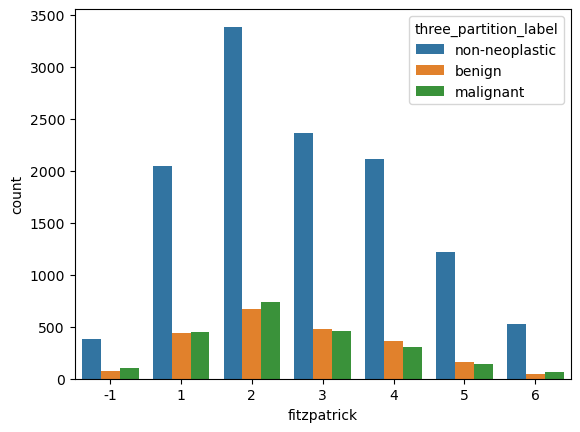

In [13]:
import seaborn as sns 

sns.countplot(data=ground_truth,x='fitzpatrick',hue='three_partition_label',order=[str(e) for e in [-1,1,2,3,4,5,6] ] )

In [14]:
experiments_list = [
    ("baseline","/home/ramon/justFineTuneTwice/results/exp_vit_224_fitzpatrickMalignancyClassification_query_val_preds.csv"),
    ("query","/home/ramon/justFineTuneTwice/results/exp_vit_224_fitzpatrickMalignancyClassification_query_val_preds.csv"),
] 

In [15]:
ground_truth['three_partition_label'].value_counts()

non-neoplastic    12034
malignant          2260
benign             2231
Name: three_partition_label, dtype: int64

In [16]:

num_task =2
all_ovs = list()
disparity = list() 
groups = {'Light':['1','2'],'Dark':['5','6']}
interval = list() 
for (exp_name,exp_path) in experiments_list:
    predictions =  pd.read_csv(exp_path)
    preds_w_labels = pd.merge( predictions,ground_truth,left_on='png_path',right_on='file')
    preds_w_labels['predLabel']= preds_w_labels[[ f"Task_{e}" for e in range(num_task) ]].values.argmax(axis=1)
    label_map = {'benign':0,'malignant':1 ,'non-neoplastic':2}
    preds_w_labels['numLabel'] = preds_w_labels['three_partition_label'].apply(lambda x: label_map[x])
    model_res = run_boostrap_exp(preds_w_labels,num_classes=num_task)
    ov_res = run_regular_exp(preds_w_labels,num_classes=num_task)
    model_res['model'] = exp_name 
    ov_res['split']='overall'
    ov_res['model'] = exp_name 
    all_ovs.append(ov_res)
    for e in groups :
        ov_res = run_regular_exp(preds_w_labels[preds_w_labels['fitzpatrick'].isin(groups[e])],num_classes=num_task)
        ov_res['split']=e
        ov_res['model'] = exp_name
        all_ovs.append(ov_res)
    interval.append(model_res)



/home/ramon/miniconda3/lib/python3.9/site-packages/pandas/core/array_algos/quantile.py:100: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  result = nanpercentile(
/home/ramon/miniconda3/lib/python3.9/site-packages/pandas/core/array_algos/quantile.py:100: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  result = nanpercentile(
/home/ramon/miniconda3/lib/python3.9/site-packages/pandas/core/array_algos/quantile.py:100: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'high

In [17]:
stuff = pd.concat(interval)
stuff

,Task_auc_int,Task_precision_int,Task_recall_int,Task_tpr_int,Task_fpr_int,Severity Class,model
0,"0.8653 (0.8572,0.8733)","0.7592 (0.7532,0.7652)","0.7823 (0.7685,0.7961)","0.7823 (0.7685,0.7961)","0.2371 (0.2286,0.2456)",0,baseline
1,"0.8648 (0.857,0.8727)","0.7851 (0.7746,0.7957)","0.7628 (0.755,0.7707)","0.7628 (0.755,0.7707)","0.2184 (0.2049,0.2319)",1,baseline
0,"0.864 (0.8557,0.8722)","0.7579 (0.7524,0.7634)","0.7804 (0.766,0.7948)","0.7804 (0.766,0.7948)","0.2378 (0.2302,0.2454)",0,query
1,"0.8651 (0.8575,0.8728)","0.7861 (0.7757,0.7965)","0.7609 (0.7524,0.7694)","0.7609 (0.7524,0.7694)","0.2173 (0.2031,0.2315)",1,query


In [18]:

stuff['model'] = pd.Categorical(stuff['model'],['baseline','query'])
stuff[['model','Severity Class','Task_auc_int','Task_precision_int','Task_recall_int','Task_fpr_int']].sort_values(by=['Severity Class','model'])

,model,Severity Class,Task_auc_int,Task_precision_int,Task_recall_int,Task_fpr_int
0,baseline,0,"0.8653 (0.8572,0.8733)","0.7592 (0.7532,0.7652)","0.7823 (0.7685,0.7961)","0.2371 (0.2286,0.2456)"
0,query,0,"0.864 (0.8557,0.8722)","0.7579 (0.7524,0.7634)","0.7804 (0.766,0.7948)","0.2378 (0.2302,0.2454)"
1,baseline,1,"0.8648 (0.857,0.8727)","0.7851 (0.7746,0.7957)","0.7628 (0.755,0.7707)","0.2184 (0.2049,0.2319)"
1,query,1,"0.8651 (0.8575,0.8728)","0.7861 (0.7757,0.7965)","0.7609 (0.7524,0.7694)","0.2173 (0.2031,0.2315)"


In [19]:
all_df = pd.concat(all_ovs).sort_values(by=['model','Severity Class','split'])

In [20]:
import numpy as np 
copied_df = all_df[all_df['split']!='overall'].sort_values(by=['Severity Class','split','model'])[['model','split','Severity Class','auc','precision','recall','tpr','fpr']]

In [21]:
copied_df

,model,split,Severity Class,auc,precision,recall,tpr,fpr
0,baseline,Dark,0,0.925,0.935,0.763,0.763,0.069
0,query,Dark,0,0.925,0.935,0.763,0.763,0.069
0,baseline,Light,0,0.846,0.727,0.782,0.782,0.267
0,query,Light,0,0.846,0.727,0.782,0.782,0.267
1,baseline,Dark,1,0.926,0.750,0.931,0.931,0.237
1,query,Dark,1,0.926,0.750,0.931,0.931,0.237
1,baseline,Light,1,0.846,0.787,0.733,0.733,0.218
1,query,Light,1,0.846,0.787,0.733,0.733,0.218


/home/ramon/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/ramon/miniconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/ramon/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/ramon/miniconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/ramon/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use

Text(0.5, 0.98, 'Performance Benign')

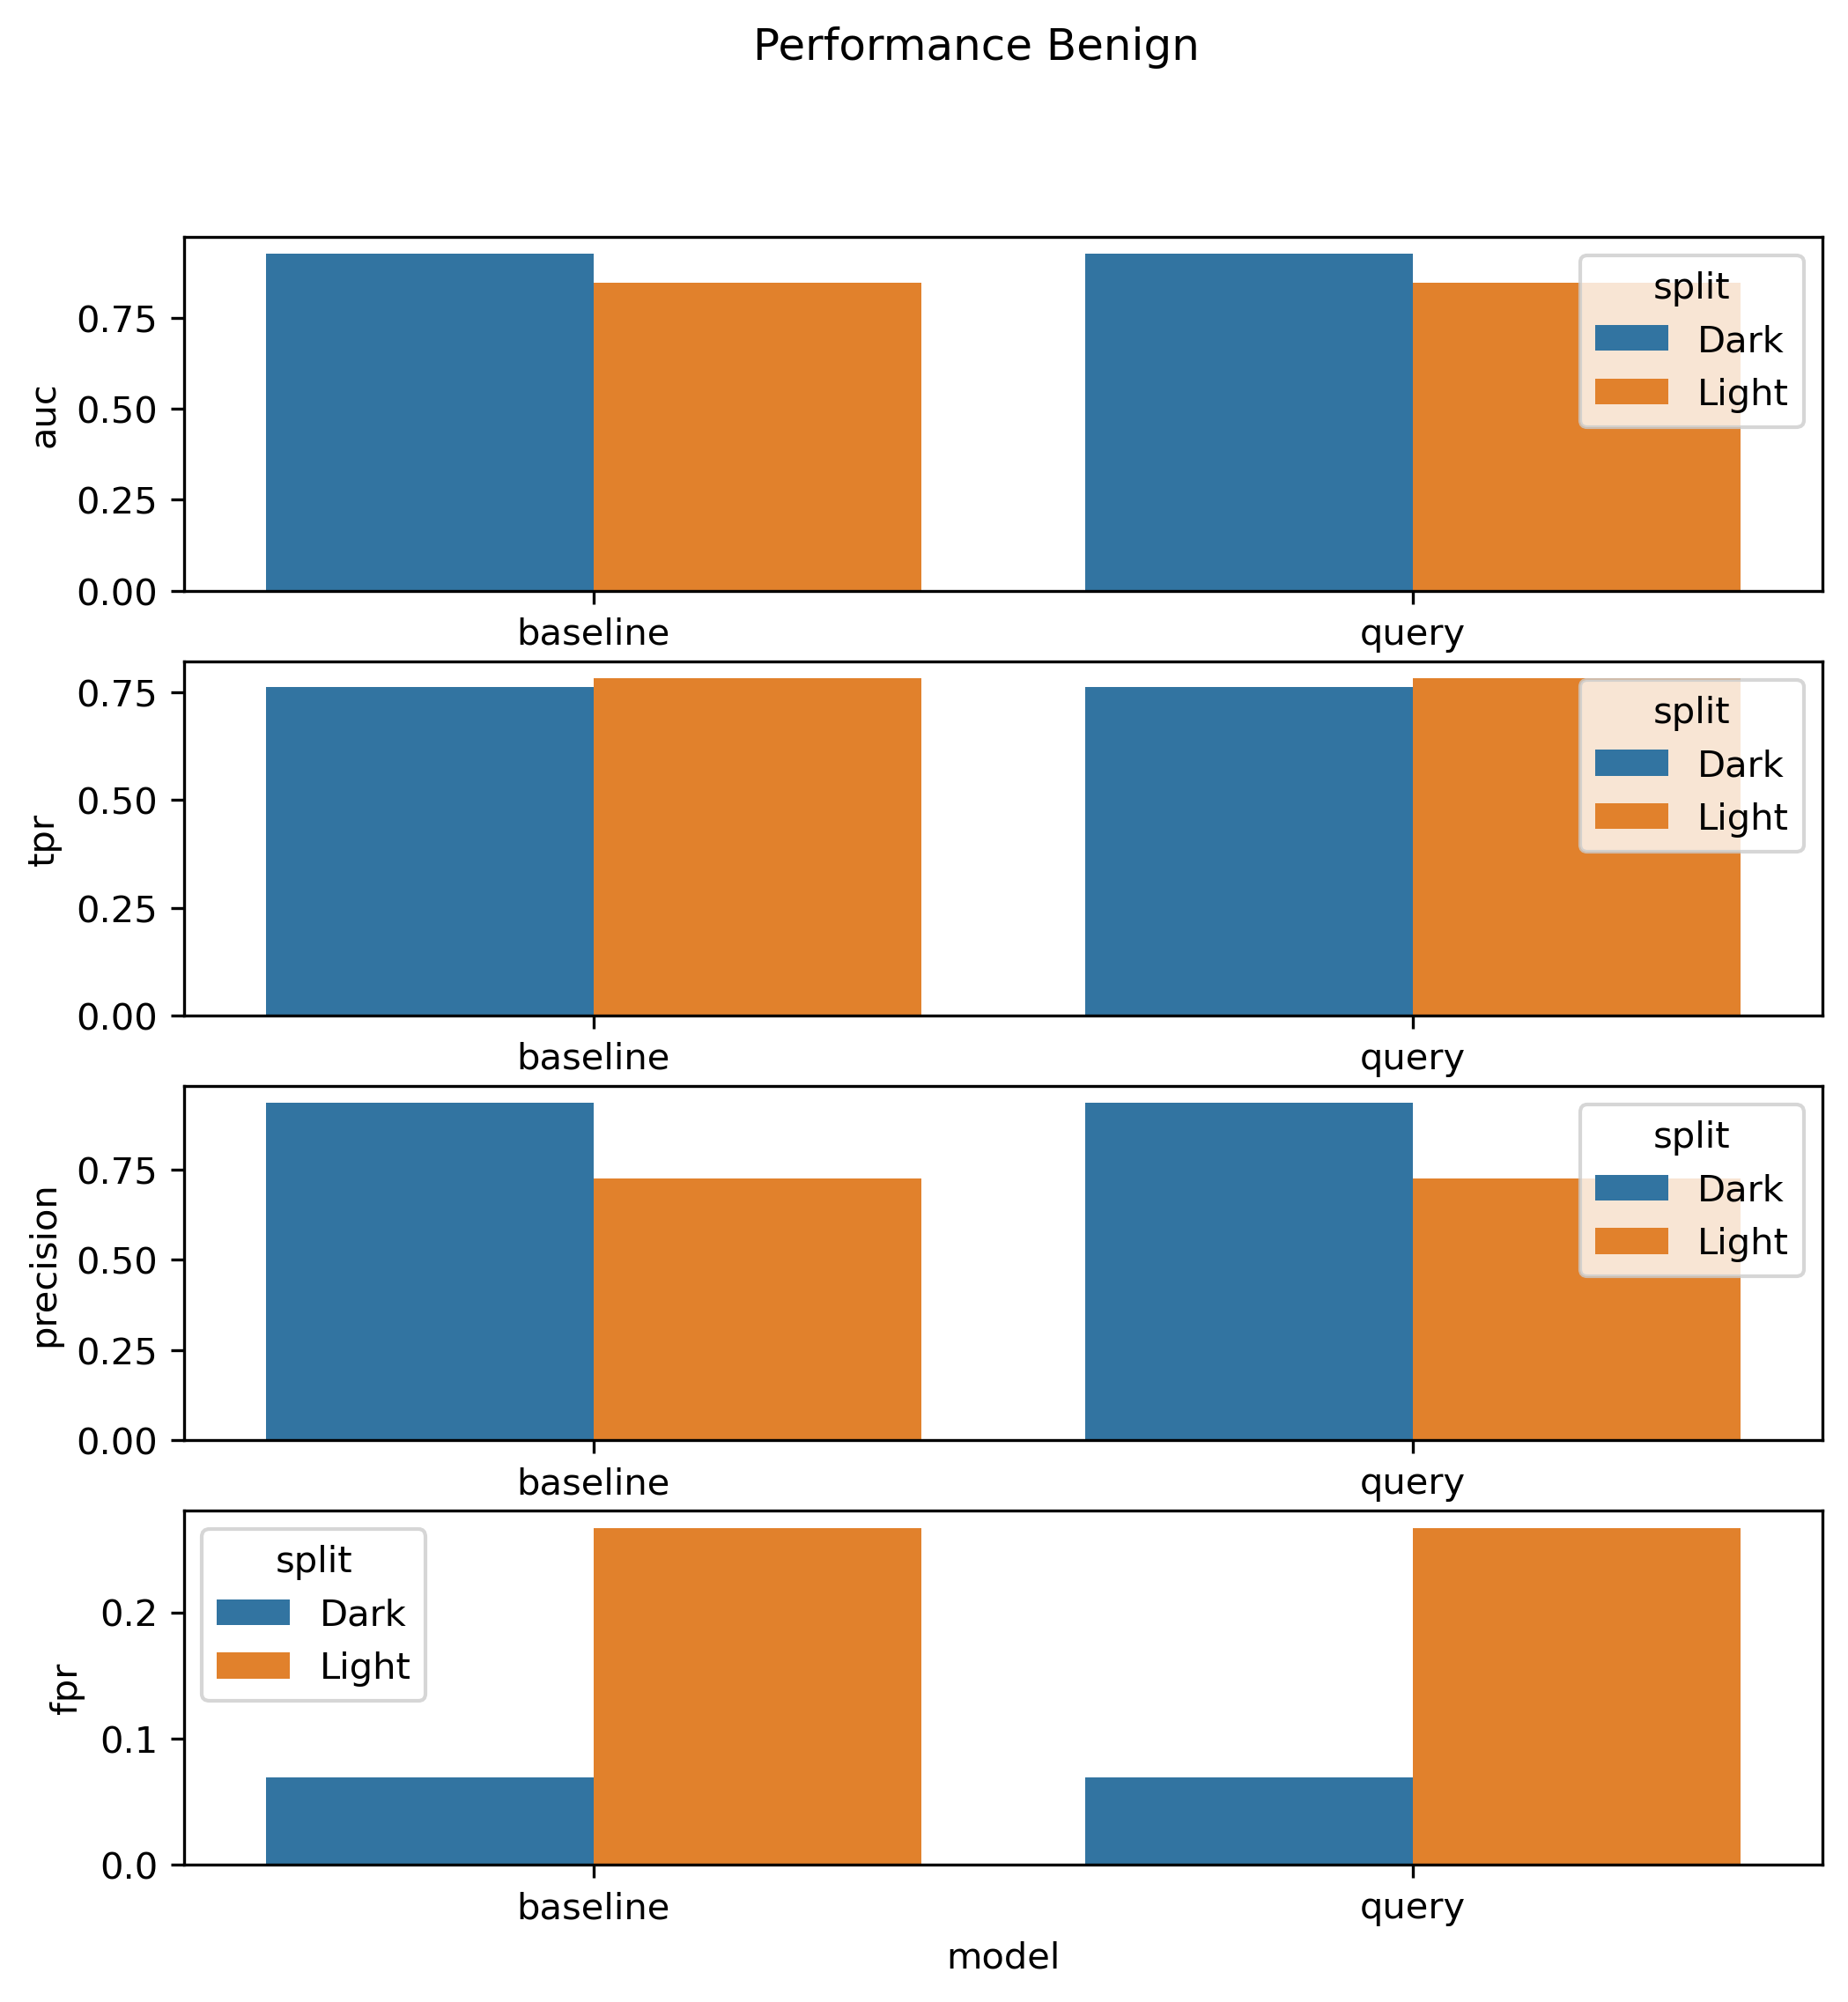

In [22]:
import seaborn as sns 

import matplotlib.pyplot as plt 
import seaborn as sns 
fig,axes = plt.subplots(4,1,dpi=300,figsize=(8,8))
for i,e in enumerate(['auc','tpr','precision','fpr']): 
    sns.barplot(data=copied_df[copied_df['Severity Class']==0],x='model',y=e,hue='split',ax=axes[i])

plt.suptitle("Performance Benign")

/home/ramon/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/ramon/miniconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/ramon/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/ramon/miniconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/ramon/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use

Text(0.5, 0.98, 'Performance Malignant')

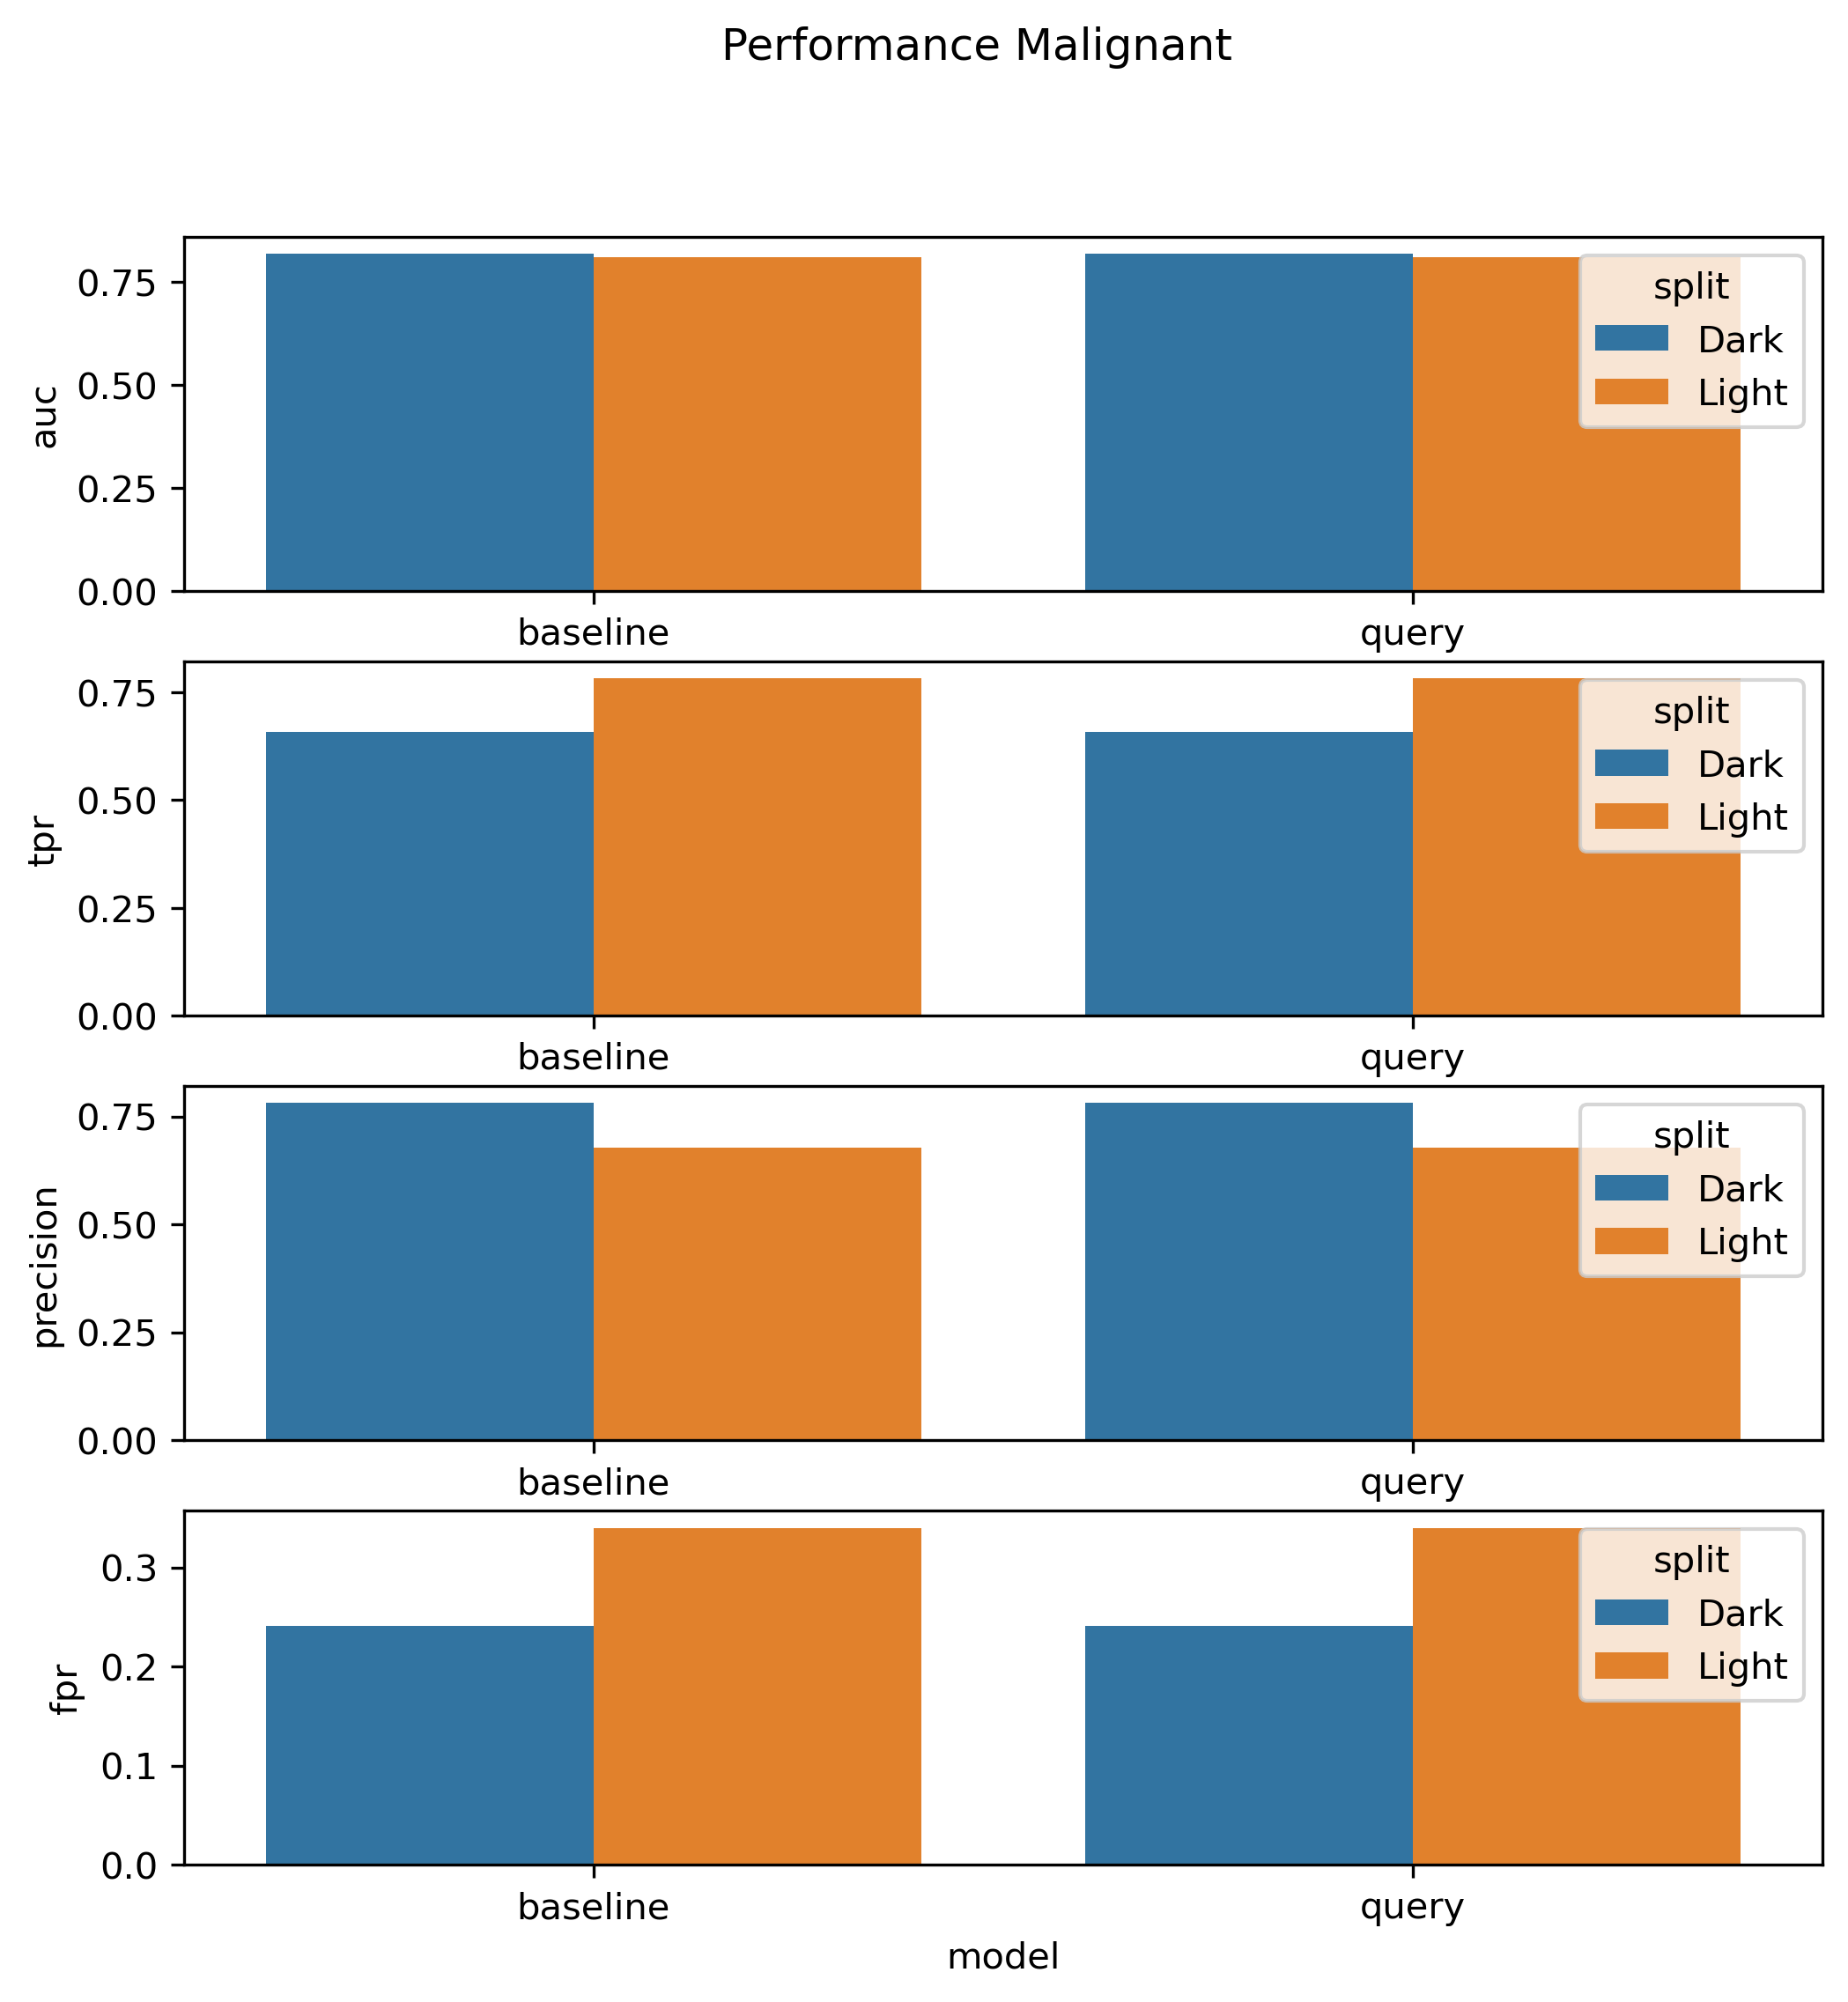

In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns 
fig,axes = plt.subplots(4,1,dpi=300,figsize=(8,8))
for i,e in enumerate(['auc','tpr','precision','fpr']): 
    sns.barplot(data=copied_df[copied_df['Severity Class']==0],x='model',y=e,hue='split',ax=axes[i])

plt.suptitle("Performance Malignant")